In [1]:
# A notebook for simple lstm exploration
import torch.nn as nn
from torch.autograd import Variable 
import torch
from core_functions import Data, Trainer, plot_train, test_accuracy
dataPath = "./second_collection_triggs_rels_32.npz"
D = Data(dataPath, triggers=True, releases=False)
D.split()
D.normalize()
D.tensors_to_device()
D.print_shapes()

Train, test and validation data normalized to:
[1.]
[1.0011533]
[1.00011294]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (7497, 1, 32) 
Labels shape:  (7497,) 
Unique labels:  [0 1 2] 
Shape of test set: (1125, 1, 32) 
Shape of train set: (5416, 1, 32) 
Shape of validation set: (956, 1, 32) 
Fraction of single class in test set:  0.31377777777777777 
dtype of inputs:  torch.float32


End of epoch 1:loss_tr=1.441, loss_val=1.416, train=33.8%, val=36.7%
End of epoch 2:loss_tr=1.420, loss_val=1.392, train=49.9%, val=51.8%
End of epoch 3:loss_tr=1.421, loss_val=1.412, train=36.0%, val=35.3%
End of epoch 4:loss_tr=1.301, loss_val=1.281, train=50.7%, val=52.2%
End of epoch 5:loss_tr=1.081, loss_val=1.072, train=51.4%, val=53.8%
End of epoch 6:loss_tr=0.970, loss_val=0.949, train=49.6%, val=49.3%
End of epoch 7:loss_tr=0.909, loss_val=0.906, train=52.8%, val=53.3%
End of epoch 8:loss_tr=0.881, loss_val=0.879, train=55.0%, val=54.6%
End of epoch 9:loss_tr=0.942, loss_val=0.943, train=52.2%, val=50.3%
End of epoch 10:loss_tr=0.877, loss_val=0.871, train=55.8%, val=55.5%
End of epoch 11:loss_tr=1.079, loss_val=1.077, train=44.4%, val=43.9%
End of epoch 12:loss_tr=0.866, loss_val=0.859, train=57.7%, val=58.4%
End of epoch 13:loss_tr=0.860, loss_val=0.857, train=56.7%, val=55.4%
End of epoch 14:loss_tr=0.878, loss_val=0.877, train=55.5%, val=54.0%
End of epoch 15:loss_tr=0.877

End of epoch 118:loss_tr=0.394, loss_val=0.361, train=84.0%, val=86.3%
End of epoch 119:loss_tr=0.412, loss_val=0.367, train=82.5%, val=84.6%
End of epoch 120:loss_tr=0.403, loss_val=0.382, train=83.3%, val=84.5%
End of epoch 121:loss_tr=0.427, loss_val=0.388, train=82.5%, val=84.6%
End of epoch 122:loss_tr=0.396, loss_val=0.380, train=83.4%, val=84.0%
End of epoch 123:loss_tr=0.610, loss_val=0.551, train=74.0%, val=74.8%
End of epoch 124:loss_tr=0.429, loss_val=0.389, train=83.3%, val=86.2%
End of epoch 125:loss_tr=0.404, loss_val=0.364, train=83.7%, val=85.6%
End of epoch 126:loss_tr=0.383, loss_val=0.348, train=84.6%, val=87.1%
End of epoch 127:loss_tr=0.423, loss_val=0.391, train=82.2%, val=83.8%
End of epoch 128:loss_tr=0.416, loss_val=0.376, train=82.6%, val=85.7%
End of epoch 129:loss_tr=0.384, loss_val=0.345, train=85.0%, val=86.3%
End of epoch 130:loss_tr=0.418, loss_val=0.370, train=82.5%, val=83.8%
End of epoch 131:loss_tr=0.393, loss_val=0.352, train=83.6%, val=85.6%
End of

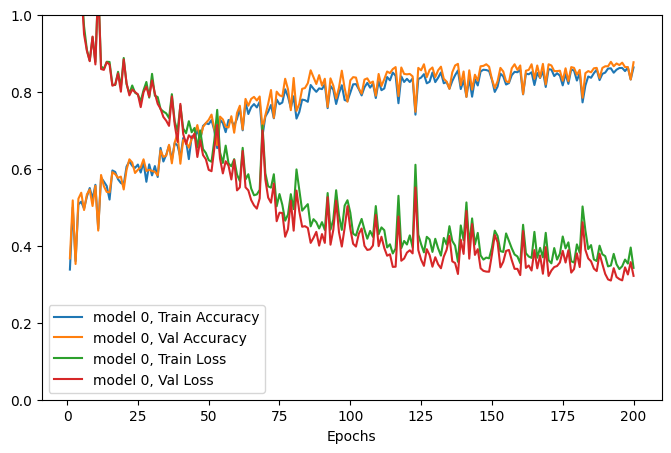

In [2]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        
        torch.manual_seed(180200742)    # Set seed for same initialization of weigths each time

        self.input_size = 4 
        self.hidden_dim = 64 
        self.out_size = 5
        self.num_layers = 1

        # shape of input ()
        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.out_size)
        # self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((x.shape[0], int(x.shape[2]/self.input_size), self.input_size))

        # # Initialize hidden state
        # h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)) #internal state

        # Propagate input through LSTM
        # print("input: ", x.shape)
        lstm_out, _ = self.lstm(x) #lstm with input, hidden, and internal state
        # print("out lstm: ", lstm_out.shape)

        lstm_out = lstm_out[:, -1, :]    # Choose final output of lstm for classification

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = self.relu(out)
        out = out.view(batch_size, -1)

        # print("output shape: ", out.shape)
        return out 
 

model = lstm() 
T = Trainer(D)
T.setup(model, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=200)
T.train_model(model)
plot_train([T])
test_accuracy(D, [model])

In [15]:
import numpy as np

A = np.arange(32)
idxs = np.arange(len(A), step=2)
print(A)
print(idxs)

L = 15
M = np.zeros((L, 4)) 
for i, idx in enumerate(idxs[:-1]):
    M[i] = A[idx:idx+4]
print(M)

# Make a mask to select positions
mask = np.full((L, 32), False)
mask[0, :4] = True
for i in range(1, len(mask)):
    mask[i] = np.roll(mask[i-1], shift=2)
print(mask)

A = A[np.newaxis, :] * np.ones((15, 1))
print(A[mask].reshape((15, 4)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30]
[[ 0.  1.  2.  3.]
 [ 2.  3.  4.  5.]
 [ 4.  5.  6.  7.]
 [ 6.  7.  8.  9.]
 [ 8.  9. 10. 11.]
 [10. 11. 12. 13.]
 [12. 13. 14. 15.]
 [14. 15. 16. 17.]
 [16. 17. 18. 19.]
 [18. 19. 20. 21.]
 [20. 21. 22. 23.]
 [22. 23. 24. 25.]
 [24. 25. 26. 27.]
 [26. 27. 28. 29.]
 [28. 29. 30. 31.]]
[[ True  True  True  True False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False  True  True  True  True False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False  True  True  True  True False False False False
  False False False False False False False False False False False False
  False False False